In [212]:
import pandas as pd
import regex as re
re.DEFAULT_VERSION = re.VERSION1
from unidecode import unidecode
import tomotopy as tp
from gensim.models.phrases import Phraser, Phrases
import time
from bertopic import BERTopic 
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load('fr_core_news_lg', disable=["ner"])

In [2]:
BERTDf = pd.read_pickle('data/le_figaro_BERT.bz')


In [223]:
topic = {'science':['découverte','scienti','science','techni',
                    'savant','érudit','invention'],
         'futur': ['avenir','futur','destin',' sort '],#'futur' introduce too much noise
         'progrès' : ['progrès','perfectionnement','developpement','innovation','modernité','évolution','amélioration'],
         'société' : ['humanité', 'civilisation','peuple','population','génération','déclin','décaden',
                      'prospér'],
         'émotion':['crainte','anxiété','sérenité',' peur','enthousias','angoisse','esper','esper']}
ignorePattern = re.compile('(?:(?:academi\W*.{,6}\W*|faculte\W*.{,6}\W*|chronique{,3}'+
                           'institu{,6}|poly.{,3}\W?|comite.{,6}\W?|\w)'+
                           '(?:scien.{,3}|techni.{,3})|progres\w{2,4}|scien\W*.{,3}(?:socia|politi)|'+
                           'clandestin|destina)')

In [224]:

yearRegex = re.compile('(?:jusqu.{,4})?(?:\W|^)(?:pendant|\Wen|\Wa|dans|pour|\Wde|d\Wici|au\Wcours|^)'+
                       '\W*.{,4}(?:(?:l|les|des|d)\W+an(?:nee?s?)?)?\W*[123]\d{3}'+
                       '(?:\W*(?:a|et|ou)?\W*[123]\d{3})*')
timeMentionRegex = re.compile('(?:dans|pendant(?:\Wencore)?|jusqu|d\Wici|au\Wcours|^)\W*.{,2}'+
                              '(?:.{,6}\W*prochaine?s?|.{,6}\W*quelques?|.{,6}\W*plusieurs)?\W*'+
                              '.{,6}\W+(?:an(?:nee)?s?|decennies?|siecles?|millenaires?|temps\Wa\W?venir|'+
                              'futurs? lointains?)\W+(?:.{,3}venir|proch(?:es?|aine?s?))?(?:\W|$)')
nextGenRegex = re.compile('(?:(?:(?:nos|vos)(?:\W*future?s?|\W*arrieres?|\W*petite?s?|\W*lointains|grands)*\W+'+
                          '(?:filleul|niece|neveu|enfant|fils|fille|descendant|gendre|petite?\Wcousine?|cadet)[sx]?)|'+
                          '(?:(?:future?s?|prochaine?s?|suivantes?)\W*.{3}\W*(?:generations?|epoques?|temps|periodes?))|'+
                          '(?:(?:generations?|epoques?|temps|periodes?)\W*.{4}\W*(?:venir|future?s?|prochaine?s?|suivante?s)))')

In [111]:
#BERTDf['preprocessed'] = BERTDf.content.str.lower().apply(unidecode)
BERTDf['preprocessed'] = BERTDf['preprocessed'].apply(lambda pp: ignorePattern.sub('',pp))

In [112]:
getTimeMention = lambda preprocessed : [mention for mention 
                                        in timeMentionRegex.findall(preprocessed)
                                        if not 'dernier' in mention and not 'passe' in mention and not 'ancien' in mention]
getYearMention = lambda preprocessed : yearRegex.findall(preprocessed)
getMaxYear = lambda yearPatterns : max([int(year) for pattern in yearPatterns for year in re.findall('[123]\d{3}',pattern)]) if len(yearPatterns) else None
getNextGen = lambda preprocessed : nextGenRegex.findall(preprocessed)
BERTDf['yearMention'] = BERTDf.preprocessed.apply(getYearMention)
BERTDf['timeMention'] = BERTDf.preprocessed.apply(getTimeMention)
BERTDf['nextGen'] = BERTDf.preprocessed.apply(getNextGen)
BERTDf['year'] = BERTDf['yearMention'].apply(getMaxYear)
BERTDf['yearDif'] = BERTDf['year']-BERTDf.ID.str.split('-').apply(lambda y : int(y[0]))

In [225]:
def getCounter(kws):
    kws = {kw:[unidecode(w) for w in kws[kw]] for kw in kws}
    return lambda kw : lambda preprocessed : sum(w in preprocessed for w in kws[kw])

BERTDf['science'] = BERTDf.preprocessed.apply(getCounter(topic)('science'))
BERTDf['futur'] = BERTDf.preprocessed.apply(getCounter(topic)('futur'))
BERTDf['progrès'] =  BERTDf.preprocessed.apply(getCounter(topic)('progrès'))
BERTDf['société'] = BERTDf.preprocessed.apply(getCounter(topic)('société'))
BERTDf['émotion'] = BERTDf.preprocessed.apply(getCounter(topic)('émotion'))

In [266]:
BERTDfFiltered = BERTDf[(((BERTDf.science+BERTDf.société*BERTDf.futur)>1).astype(int)+
                         ((BERTDf.futur+BERTDf['progrès']*BERTDf.futur)>0).astype(int)+
                         (BERTDf.timeMention.apply(len)>0).astype(int)+
                         (BERTDf.nextGen.apply(len)>0).astype(int)+
                         (BERTDf.yearDif>2).astype(int)+((BERTDf.futVerb>5)|
                         (BERTDf.futVerb*BERTDf.cndVerb>4)).astype(int)+
                         (BERTDf.futVerb>1).astype(int))>2]

In [267]:
BERTDfFiltered

,ID,headline,segmentID,content,lemmas,cndVerb,futVerb,tokens,preprocessed,yearMention,timeMention,nextGen,year,yearDif,science,futur,société,émotion,progrès
394,1898-03-26_1_32_0,LA CHAMBRE Vendredi 25,0,mars . DU HAVRE A NEW YORK Que d'eau que d'eau...,"[mars, havre, new, york, eau, eau, poincaré, p...",0,7,"[2, 1556, 18, 1637, 18166, 37, 17970, 21154, 2...",mars . du havre a new york que d'eau que d'eau...,[],[],[],NaN,NaN,1,2,0,2,1
1052,1898-04-04_1_22_0,,0,M. Ranc écrit dans le Radical que l'attitude d...,"[ranc, écrire, radical, attitude, méline, estp...",2,7,"[2, 49, 18, 19128, 223, 2087, 422, 354, 30351,...",m. ranc ecrit dans le radical que l'attitude d...,[],[dans le siecle : ],[],NaN,NaN,0,0,0,0,0
1268,1898-04-07_0_21_1,,1,- une école dentaire. Mais elles sont encore ;...,"[école, dentaire, trop, jeune, exercer, action...",0,4,"[2, 17, 408, 3119, 2880, 450, 18, 811, 1306, 5...",- une ecole dentaire. mais elles sont encore ;...,[],[],[],NaN,NaN,2,1,0,2,0
1423,1898-04-09_1_3_0,,0,Le commencement du vingtième siècle verra sanê...,"[commencement, vingtième, siècle, voir, doute,...",0,4,"[2, 447, 7363, 378, 25124, 3757, 9714, 5036, 2...",le commencement du vingtieme siecle verra sane...,[],"[dans quelques annees, ]",[],NaN,NaN,0,1,0,2,0
1502,1898-04-10_2_7-8-9_4,REVDE DES JOURNAUX,4,"Cette conclusion s'imposait. Les politiques, c...","[conclusion, imposer, politique, comprendre, n...",0,6,"[2, 1336, 8176, 86, 11, 25439, 18, 519, 3750, ...","cette conclusion s'imposait. les politiques, c...",[],[dans le siecle : ],[],NaN,NaN,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789701,1878-04-21_0_23_1,LE BARYTON-SOLEIL,1,"On ne verra pas sa majestueuse personnalité, l...","[voir, majestueux, personnalité, jour, lumière...",3,6,"[2, 639, 446, 9714, 435, 488, 1696, 1161, 7112...","on ne verra pas sa majestueuse personnalite, l...",[],[],[],NaN,NaN,0,1,0,0,0
789914,1878-04-24_2_1-2_2,,2,Je vous prie donc d'inviter les chefs de légio...,"[prier, inviter, chef, légion, placer, étendue...",0,7,"[2, 667, 578, 5929, 1190, 71, 11, 16884, 361, ...",je vous prie donc d'inviter les chefs de legio...,[],[],[],NaN,NaN,0,1,1,0,0
790127,1878-04-27_0_34-35-36-37_4,Première Partie LE MASQUE DE VELOURS,4,"Il consent à vous l'accorder et, à voire retou...","[consentir, accorder, voire, demander, être, a...",2,3,"[2, 528, 6861, 130, 578, 79, 11, 7884, 353, 16...","il consent a vous l'accorder et, a voire retou...",[],[],[],NaN,NaN,0,1,0,0,0
791523,1878-05-10_2_16_3,PETITE GAZETTE,3,Une sueur froide perla tout à coup sur les tem...,"[sueur, froid, perla, coup, tempe, vieux, dire...",7,2,"[2, 1064, 25595, 14395, 703, 1122, 521, 130, 9...",une sueur froide perla tout a coup sur les tem...,[],[],[],NaN,NaN,0,1,1,0,0


In [154]:
yCount = BERTDf.ID.str.split('-').apply(lambda y : int(y[0])).value_counts()

<AxesSubplot:>

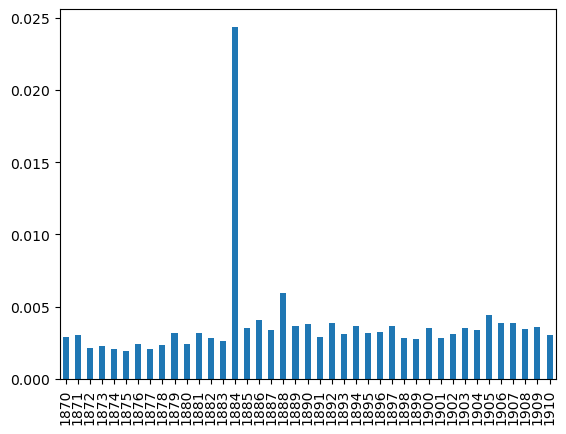

In [163]:
test = (BERTDfFiltered.ID.str.split('-').apply(lambda y : int(y[0])).value_counts())/yCount
test = test.sort_index()
yCount = yCount.sort_index()
test.plot.bar()

## Topic modelling for evalutation

### BERTopic

In [190]:
topic_model = BERTopic(verbose=True, min_topic_size = 10, language=None,
                       embedding_model='dbmdz/bert-base-french-europeana-cased')
topics, probs = topic_model.fit_transform(BERTDfFiltered.content.tolist())
topic_model.save('models/BERTopicFiltered.bin')
topic_model.get_topic_info()

2023-01-26 12:34:06,810 - BERTopic - Transformed documents to Embeddings
2023-01-26 12:34:15,373 - BERTopic - Reduced dimensionality
2023-01-26 12:34:15,563 - BERTopic - Clustered reduced embeddings


In [188]:
topic_model = BERTopic.load('models/BERTopicFiltered.bin')

In [206]:
new_topics = topic_model.reduce_outliers(BERTDfFiltered.content.tolist(),topics,threshold=0.2)

100%|█████████████████████████████████████████████| 2/2 [00:04<00:00,  2.23s/it]


In [216]:
pd.Series(new_topics).value_counts().head(20)

 0     583
-1     457
 2     456
 1     289
 3     286
 17    179
 20    119
 27    119
 5     115
 4     115
 6     110
 36    109
 9      96
 7      95
 15     87
 32     71
 8      67
 13     65
 10     61
 26     59
dtype: int64

In [220]:
vectorizer_model = CountVectorizer(ngram_range=(1,3), 
                                   max_df = 0.75,
                                   min_df = 5,
                                   strip_accents = 'unicode',
                                   lowercase = True,
                                   stop_words = [unidecode(stop) for stop in nlp.Defaults.stop_words])
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True,bm25_weighting=True)
topic_model.update_topics(BERTDfFiltered.content.tolist(),new_topics, diversity = 0.2,
                          vectorizer_model=vectorizer_model,
                          ctfidf_model = ctfidf_model)

In [221]:
getHalfDecadeString = lambda halfDecade : str(halfDecade) +'-'+str(halfDecade+5)
getHalfDecade = lambda year : int(int(year)/5)*5
topics_over_time = topic_model.topics_over_time(BERTDfFiltered.content.tolist(), 
                                                [getHalfDecade(ID.split('-')[0]) for ID in BERTDfFiltered.ID],
                                                nr_bins = 8,
                                                global_tuning=True)

8it [00:16,  2.12s/it]


In [222]:
topics_over_time.Timestamp=topics_over_time.Timestamp.apply(round).apply(getHalfDecadeString)
topic_model.visualize_topics_over_time(topics_over_time,normalize_frequency=False,top_n_topics=20)

### Pachinko allocation

In [ ]:
raw_articles = BERTDfFiltered["lemmas"].tolist()
bigram = Phrases(raw_articles, min_count=5, threshold=10)
bigram_mod = Phraser(bigram)
raw_articles = list(bigram_mod[raw_articles])
trigram = Phrases(raw_articles, min_count=5, threshold=10)
trigram_mod = Phraser(bigram)
raw_articles = list(trigram_mod[raw_articles])
#BERTDfFiltered["nGram"] = raw_articles
#BERTDfFiltered["nGram"] = BERTDfFiltered["nGram"].apply(' '.join)
#BERTDfFiltered["lemmatized"] = BERTDfFiltered["lemmatized"].apply(' '.join)

In [118]:
corpus = tp.utils.Corpus()
for doc in raw_articles:
    if len(doc)>5:
        corpus.add_doc(doc)

In [122]:
len(corpus)

1788

In [140]:
pd.Series(raw_articles).explode().value_counts().head(10)

faire      1273
être       1159
bien        963
grand       830
pouvoir     815
vouloir     672
venir       600
jour        581
voir        575
falloir     563
dtype: int64

In [124]:
k1_max = 10
k1_min = 1 
k2_max = 16
k2_min = 6
params = []
scores = []
num_iter = 0
max_iter = 0
for k1 in range(k1_min, k1_max):
    for k2 in range(max(k1,k2_min),k2_max):
        max_iter +=1
        
start = time.time()
for k1 in range(k1_min, k1_max):
    for k2 in range(max(k1,k2_min),k2_max):
        num_iter+=1
        model = tp.PAModel(tw=tp.TermWeight.IDF,min_cf = 5, min_df=1, rm_top=10, k1=k1, k2=k2, corpus=corpus)
        model.burn_in = 200
        model.train(800, workers=20)
        score = tp.coherence.Coherence(model, coherence="c_v").get_score()
        params.append((k1,k2))
        scores.append(score)
        print("Runtime: %.2f seconds" %(time.time() - start), "|| Number of Searches: %s out of  %s" %(num_iter, max_iter), "|| k1: %s & k2: %s || coherence : %.3f" %(k1,k2,score))

Runtime: 7.77 seconds || Number of Searches: 1 out of  84 || k1: 1 & k2: 6 || coherence : 0.293
Runtime: 17.00 seconds || Number of Searches: 2 out of  84 || k1: 1 & k2: 7 || coherence : 0.132
Runtime: 25.88 seconds || Number of Searches: 3 out of  84 || k1: 1 & k2: 8 || coherence : 0.373
Runtime: 34.98 seconds || Number of Searches: 4 out of  84 || k1: 1 & k2: 9 || coherence : 0.339
Runtime: 44.77 seconds || Number of Searches: 5 out of  84 || k1: 1 & k2: 10 || coherence : 0.232
Runtime: 56.20 seconds || Number of Searches: 6 out of  84 || k1: 1 & k2: 11 || coherence : 0.259
Runtime: 68.20 seconds || Number of Searches: 7 out of  84 || k1: 1 & k2: 12 || coherence : 0.312
Runtime: 81.50 seconds || Number of Searches: 8 out of  84 || k1: 1 & k2: 13 || coherence : 0.132
Runtime: 95.31 seconds || Number of Searches: 9 out of  84 || k1: 1 & k2: 14 || coherence : 0.180
Runtime: 109.64 seconds || Number of Searches: 10 out of  84 || k1: 1 & k2: 15 || coherence : 0.160
Runtime: 117.87 seconds

Runtime: 1179.11 seconds || Number of Searches: 84 out of  84 || k1: 9 & k2: 15 || coherence : 0.608


In [126]:
for ind,score in enumerate(scores):
    if score>max(scores)*0.95:
        print("k1: %s & k2: %s || coherence : %.3f" %(params[ind][0],params[ind][1],score))


k1: 3 & k2: 10 || coherence : 0.689
k1: 4 & k2: 10 || coherence : 0.664
k1: 8 & k2: 10 || coherence : 0.657


In [131]:
model = tp.PAModel(tw=tp.TermWeight.IDF,min_cf = 5, min_df=1, rm_top=10, k1=3, k2=10, corpus=corpus)
model.train(1200, workers=15)
print(tp.coherence.Coherence(model, coherence="c_v").get_score())

0.5561943851411343


In [134]:
for k in range(10):
    print('Topic #{}'.format(k))
    print("\t", [w for w, p in model.get_topic_words(k)])

Topic #0
	 ['industrie', 'cuirassé', 'navire', 'chemin_fer', 'automobile', 'machine', 'mer', 'kilomètre', 'marine', 'flotte']
Topic #1
	 ['franc', 'gouvernement', 'allemand', 'guerre', 'angleterre', 'allemagne', 'intérêt', 'russie', 'pays', 'français']
Topic #2
	 ['science', 'peuple', 'humanité', 'homme', 'esprit', 'humain', 'progrès', 'civilisation', 'génie', 'savant']
Topic #3
	 ['prince', 'mme', 'famille', 'monsieur', 'dame', 'princesse', 'poindre', 'femme', 'reine', 'joli']
Topic #4
	 ['exposition', 'théâtre', 'paris', 'salle', 'rue', 'artiste', 'concours', 'lieu', 'salon', 'fête']
Topic #5
	 ['service', 'commission', 'budget', 'général', 'militaire', 'conseil', 'million', 'officier', 'ouvrier', 'ministre']
Topic #6
	 ['enfant', 'avoir', 'homme', 'jamais', 'petit', 'savoir', 'chose', 'bon', 'dire', 'rien']
Topic #7
	 ['droit', 'cas', 'loi', 'aucun', 'question', 'intérêt', 'gaz', 'temps', 'difficulté', 'devoir']
Topic #8
	 ['savant', 'découverte', 'pasteur', 'science', 'professeur',

In [407]:
for k in range(3):
    print('Topic #{}'.format(k))
    for word in ['avenir','progrès','science']:
        print("\t", f'{word}: ', model.get_sub_topic_dist(k,normalize=False)[list(model.used_vocabs).index(word)])

Topic #0
	 avenir:  7840.588
	 progrès:  30368.375


IndexError: index 104 is out of bounds for axis 0 with size 9

In [133]:
for k in range(9):
    print('Topic #{}'.format(k))
    for word in ['avenir','progrès','science','futur']:
        print("\t", f'{word}: ', model.get_topic_word_dist(k,normalize=False)[list(model.used_vocabs).index(word)])
model.get_count_by_topics()

Topic #0
	 avenir:  51.174107
	 progrès:  158.5753
	 science:  57.09332
	 futur:  45.595802
Topic #1
	 avenir:  42.145065
	 progrès:  57.670887
	 science:  0.0100038145
	 futur:  0.01
Topic #2
	 avenir:  112.87647
	 progrès:  209.02797
	 science:  294.21765
	 futur:  60.790752
Topic #3
	 avenir:  0.01
	 progrès:  0.010141859
	 science:  0.01
	 futur:  45.593903
Topic #4
	 avenir:  0.010001907
	 progrès:  14.425056
	 science:  0.01004673
	 futur:  0.010345707
Topic #5
	 avenir:  16.563898
	 progrès:  37.849304
	 science:  0.01
	 futur:  52.10477
Topic #6
	 avenir:  279.9235
	 progrès:  82.89712
	 science:  28.552141
	 futur:  95.52155
Topic #7
	 avenir:  84.28402
	 progrès:  23.434423
	 science:  0.01
	 futur:  115.05687
Topic #8
	 avenir:  0.01
	 progrès:  9.019371
	 science:  182.23938
	 futur:  0.01


array([10437, 12122, 10743,  5804, 12030, 13477, 37457, 14528,  2419,
       13579], dtype=uint64)

In [491]:

model.get_topic_word_dist(k,normalize=True)

array([1.4804439e-03, 2.6846319e-03, 1.1442521e-04, ..., 5.7579484e-07,
       5.7579484e-07, 5.7579484e-07], dtype=float32)

In [410]:
BERTDfFiltered.loc[:,'docs'] = model.docs

/tmp/ipykernel_560281/2581417065.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BERTDfFiltered.loc[:,'docs'] = model.docs


In [414]:
BERTDfFiltered.loc[:,'topics'] = BERTDfFiltered['docs'].apply(lambda x : x.get_sub_topics()).apply(dict)

/tmp/ipykernel_560281/1049310590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BERTDfFiltered.loc[:,'topics'] = BERTDfFiltered['docs'].apply(lambda x : x.get_sub_topics()).apply(dict)


In [422]:
BERTDfFiltered[BERTDfFiltered.topics.apply(lambda x : x.get(6)>0.2)]

,ID,headline,segmentID,content,lemmas,cndVerb,futVerb,tokens,preprocessed,yearMention,timeMention,year,nextGen,yearDif,science,futur,société,émotion,docs,topics
1220,1898-04-06_2_22_1,; ÉLECTION A L'ACADÉMIE DE MÉDECINE LE PROFESS...,1,"Nous possédons de lui, un beau volume de Leçon...","[posséder, beau, volume, leçon, physiologie, m...",0,1,"[2, 970, 7696, 406, 336, 558, 16, 390, 1060, 5...","nous possedons de lui, un beau volume de lecon...","[ des 1888, en l'an 2000]",[],2000.0,[],102.0,2,0,0,0,"(posséder, beau, volume, leçon, physiologie, m...","{6: 0.40202274918556213, 7: 0.3177270889282226..."
7208,1898-07-09_0_15-16-17_5,i A. KT3Sr03Sr0ES ET BÉOLAMB. S Agence P. DOLU...,5,Et ils avaient eu bien plus de plaisir. Leurs ...,"[bien, plaisir, demande, rayer, mieux, imiter,...",0,5,"[2, 646, 677, 1291, 925, 617, 467, 336, 3906, ...",et ils avaient eu bien plus de plaisir. leurs ...,[],[pendant les annees de college et d'universite...,NaN,[],NaN,1,1,0,0,"(bien, plaisir, demande, rayer, mieux, imiter,...","{7: 0.5765165686607361, 6: 0.419906347990036, ..."
7780,1898-07-19_0_10-11-12_4,LE LATIN ET L'HISTOIRE ;,4,Le Moloch exige maintenant la richesse capital...,"[moloch, exiger, richesse, capitaliser, dévore...",0,4,"[2, 447, 11319, 6430, 6327, 2382, 348, 11498, ...",le moloch exige maintenant la richesse capital...,[],[],NaN,[],NaN,0,2,1,0,"(moloch, exiger, richesse, capitaliser, dévore...","{7: 0.42123547196388245, 6: 0.2074756771326065..."
11708,1898-09-25_3_18_2,,2,L'èsprit d'irréligion et de scepticisme est de...,"[irréligion, scepticisme, descendre, haut, voi...",1,3,"[2, 48, 11, 10330, 1705, 71, 11, 4667, 9862, 4...",l'esprit d'irreligion et de scepticisme est de...,[],[],NaN,[],NaN,0,2,0,0,"(irréligion, scepticisme, descendre, haut, voi...","{0: 0.33924973011016846, 7: 0.3085785806179046..."
23266,1899-03-16_3_41-42_0,,0,"qui annule un acte de l'état-civil dans, leque...","[annule, acte, état, civil, femme, déclarer, e...",1,1,"[2, 405, 736, 2792, 390, 2557, 336, 79, 11, 13...","qui annule un acte de l'etat-civil dans, leque...",[],[],NaN,[mes enfants],NaN,2,0,0,0,"(annule, acte, état, civil, femme, déclarer, e...","{7: 0.47355887293815613, 6: 0.2495788335800171..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717340,1875-09-19_0_15-16_0,,0,"feesjsoldats à l'européenne , se défait dè-laH...","[européen, défaire, milice, publier, moniteur,...",0,2,"[2, 3007, 333, 6345, 3688, 800, 130, 79, 11, 1...","feesjsoldats a l'europeenne , se defait de-lah...",[],[],NaN,[],NaN,0,2,0,0,"(européen, défaire, milice, publier, moniteur,...","{7: 0.5001457333564758, 6: 0.22253844141960144..."
743007,1876-07-11_0_23_0,GRAINS DE BON SENS,0,Dn ancienpion demande la parole : Je ne parler...,"[demande, parole, parler, scandale, venir, lie...",2,3,"[2, 17020, 1447, 2176, 335, 1260, 348, 3287, 3...",dn ancienpion demande la parole : je ne parler...,[],[],NaN,[],NaN,0,2,0,0,"(demande, parole, parler, scandale, venir, lie...","{6: 0.5023974180221558, 7: 0.20796357095241547..."
754423,1876-12-25_1_9-10-11_6,,6,Quoi lorsque tant d'objets merveilleux et util...,"[objet, merveilleux, utile, solliciter, curios...",3,2,"[2, 7270, 3068, 1286, 71, 11, 4720, 9057, 353,...",quoi lorsque tant d'objets merveilleux et util...,[],[],NaN,[nos enfants],NaN,1,0,1,0,"(objet, merveilleux, utile, solliciter, curios...","{7: 0.595535159111023, 6: 0.3659076690673828, ..."
759005,1877-03-04_0_15-16-17-18_1,,1,"Déjà, chez les Beni-Mozab, on fait griller les...","[beni, griller, cuisse, sauterelle, grignote, ...",1,1,"[2, 9274, 16, 1099, 361, 28778, 17, 9365, 443,...","deja, chez les beni-mozab, on fait griller les...",[],[],NaN,[],NaN,0,2,0,0,"(beni, griller, cuisse, sauterelle, grignote, ...","{2: 0.44976237416267395, 6: 0.2220492511987686..."


<AxesSubplot:ylabel='Frequency'>

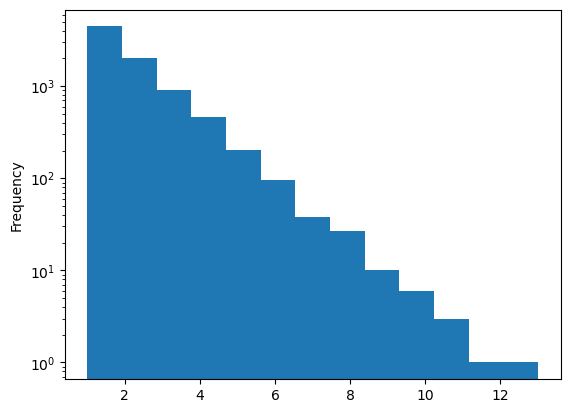

In [286]:
BERTDf[(BERTDf.timeMention.apply(len)>0)&(BERTDf.futVerb>0)].futVerb.plot.hist(logy=True,bins=13)

In [465]:
len(corpus)

1869